In [36]:
import os
import logging
import numpy as np
import pandas as pd

from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import glidenet
import utils


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv()
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
load_dotenv()

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [5]:
query = """
WITH
launches AS (
    SELECT
        name as launch,
        latitude,
        longitude,
        altitude,
        glideator.get_gfs_coords(latitude::numeric, longitude::numeric) AS gfs_coords
    FROM glideator_mart.dim_launches
),
stats AS (
    SELECT
        launch,
        date,
        max_points
    FROM glideator_mart.mart_daily_flight_stats
),
features AS (
    SELECT
        launches.launch,
        launches.latitude,
        launches.longitude,
        launches.altitude,
        gfs.*
    FROM source.gfs gfs
    JOIN launches 
    ON gfs.lat = launches.gfs_coords[1]
    AND gfs.lon = launches.gfs_coords[2]
),
features_with_target AS (
    SELECT
        features.*,
        stats.max_points
    FROM features
    JOIN stats
    ON features.launch = stats.launch
    AND features.date = stats.date
)
SELECT * FROM features_with_target
"""
df = pd.read_sql(query, engine)
df = glidenet.add_date_features(df)
df = glidenet.add_targets(df)
df.head()


,launch,latitude,longitude,altitude,lat,lon,u_wind_500hpa_ms,u_wind_550hpa_ms,u_wind_600hpa_ms,u_wind_650hpa_ms,u_wind_700hpa_ms,u_wind_750hpa_ms,u_wind_800hpa_ms,u_wind_850hpa_ms,u_wind_900hpa_ms,u_wind_925hpa_ms,u_wind_950hpa_ms,u_wind_975hpa_ms,u_wind_1000hpa_ms,v_wind_500hpa_ms,v_wind_550hpa_ms,v_wind_600hpa_ms,v_wind_650hpa_ms,v_wind_700hpa_ms,v_wind_750hpa_ms,v_wind_800hpa_ms,v_wind_850hpa_ms,v_wind_900hpa_ms,v_wind_925hpa_ms,v_wind_950hpa_ms,v_wind_975hpa_ms,v_wind_1000hpa_ms,u_wind_10m_ms,u_wind_100m_ms,v_wind_10m_ms,v_wind_100m_ms,wind_gust_sfc_ms,temperature_500hpa_k,temperature_550hpa_k,temperature_600hpa_k,temperature_650hpa_k,temperature_700hpa_k,temperature_750hpa_k,temperature_800hpa_k,temperature_850hpa_k,temperature_900hpa_k,temperature_925hpa_k,temperature_950hpa_k,temperature_975hpa_k,temperature_1000hpa_k,temperature_2m_k,temperature_80m_k,temperature_100m_k,dewpoint_2m_k,pressure_sfc_pa,precipitable_water_clm_kg_m2,relative_humidity_500hpa_pct,relative_humidity_550hpa_pct,relative_humidity_600hpa_pct,relative_humidity_650hpa_pct,relative_humidity_700hpa_pct,relative_humidity_750hpa_pct,relative_humidity_800hpa_pct,relative_humidity_850hpa_pct,relative_humidity_900hpa_pct,relative_humidity_925hpa_pct,relative_humidity_950hpa_pct,relative_humidity_975hpa_pct,relative_humidity_1000hpa_pct,geopotential_height_500hpa_m,geopotential_height_550hpa_m,geopotential_height_600hpa_m,geopotential_height_650hpa_m,geopotential_height_700hpa_m,geopotential_height_750hpa_m,geopotential_height_800hpa_m,geopotential_height_850hpa_m,geopotential_height_900hpa_m,geopotential_height_925hpa_m,geopotential_height_950hpa_m,geopotential_height_975hpa_m,geopotential_height_1000hpa_m,geopotential_height_sfc_m,date,run,delta,ref_time,max_points,weekend,year,day_of_year_sin,day_of_year_cos,XC0,XC10,XC20,XC30,XC40,XC50
0,Javorový,49.62890,18.62730,923,49.75,18.75,16.91,16.36,15.74,15.61,13.76,10.50,8.90,7.60,5.60,2.80,0.72,0.32,0.32,-8.07,-5.11,-1.94,-1.14,-1.16,-1.06,0.68,3.80,8.40,8.02,6.06,4.72,4.72,0.32,0.52,4.44,5.63,6.4,251.3,255.3,257.8,260.2,264.0,267.7,270.3,272.0,273.7,274.0,274.3,276.0,277.4,275.84,275.0,274.8,272.03,96910.625,7.2,93.5,90.7,88.1,72.9,45.3,27.4,16.9,11.1,28.2,52.1,75.0,74.5,74.5,5523.1150,4815.7740,4161.6484,3554.4143,2985.5588,2448.2470,1939.6549,1458.2020,1001.47766,781.58600,567.38590,357.68457,152.18715,406.8806,2015-01-15,12,0,2015-01-15 12:00:00,0.0,0,2015,0.255182,0.966893,0,0,0,0,0,0
1,Zvičina,50.45535,15.69635,652,50.50,15.75,22.03,18.82,13.14,9.55,8.82,8.06,4.66,1.00,0.30,0.57,0.61,0.29,0.29,19.50,17.85,16.72,14.32,12.03,5.82,-0.08,-5.24,-4.61,-3.24,-1.26,-0.47,-0.47,0.33,0.56,-0.34,-1.12,0.6,248.5,253.5,257.8,261.6,265.1,266.7,268.1,270.1,272.4,273.5,274.8,276.2,277.5,274.70,275.0,274.9,274.17,96349.440,13.4,100.0,100.0,99.1,96.4,94.9,98.5,98.6,93.7,94.2,92.1,88.7,87.6,87.6,5474.1010,4773.3784,4121.7114,3512.5542,2939.9648,2402.0874,1895.8503,1417.5238,962.67413,743.27966,528.75433,318.76196,113.08537,414.8806,2015-01-17,12,0,2015-01-17 12:00:00,0.0,1,2015,0.288291,0.957543,0,0,0,0,0,0
2,Javorový,49.62890,18.62730,923,49.75,18.75,7.16,4.94,2.78,2.27,1.80,1.21,1.05,0.35,-0.65,-1.55,-1.80,-1.46,-1.46,11.20,8.56,6.27,4.93,3.59,3.38,5.47,7.53,4.37,2.89,1.37,0.99,0.99,-1.34,-1.76,0.88,1.30,2.4,246.9,251.4,255.5,259.8,263.8,266.3,267.3,269.5,272.8,273.9,275.4,277.1,278.4,276.50,275.7,275.5,271.90,96370.240,8.8,99.7,98.9,81.8,50.5,22.2,27.5,68.7,91.3,80.9,76.4,74.1,71.1,71.1,5442.2188,4746.6620,4100.9253,3496.9460,2928.6067,2392.8105,1888.4103,1411.7135,957.23236,737.50336,522.74490,312.21793,105.95250,406.8806,2015-01-20,12,0,2015-01-20 12:00:00,0.0,0,2015,0.337301,0.941397,0,0,0,0,0,0
3,Javorový,49.62890,18.62730,923,49.75,18.75,-6.22,-6.26,-5.81,-5.33,-5.58,-8.35,-10.63,-8.38,-5.17,-2.60,-1.75,-1.24,-1.24,3.80,3.97,3.38,3.17,3.96,2.39,-2.46,-4.66,-7.08,-7.11,-6.15,-5.06,-5.06,-1.19,-1.62,-4.74,-5.95,7.3,248.0,253.5,258.2,262.2,265.2,267.6,267.9,267.9,267.9,268.6,270.4,272.2,273.5,271.92,271.0,270.8,270.

In [21]:
launch_features = ['latitude', 'longitude', 'altitude']
date_features = ['weekend', 'year', 'day_of_year_sin', 'day_of_year_cos']
targets = [col for col in df.columns if col.startswith('XC')]
weather_features = [col for col in df.columns if col not in launch_features + date_features + targets + ['launch', 'date', 'max_points', 'lat', 'lon', 'ref_time', 'run', 'delta']]
features = launch_features + date_features + weather_features


In [22]:
y = df[targets]
X = df.drop(columns=targets)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
launch_indexer = LabelEncoder()
train_launch_encoded = launch_indexer.fit_transform(X_train['launch'])
val_launch_encoded = launch_indexer.transform(X_val['launch'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

launch_train_tensor = torch.LongTensor(train_launch_encoded)
launch_val_tensor = torch.LongTensor(val_launch_encoded)
y_train_tensor = torch.FloatTensor(y_train.values)
y_val_tensor = torch.FloatTensor(y_val.values)

In [29]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), launch_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), launch_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [32]:
model = glidenet.GlideatorNet(
    input_dim=X_train_scaled.shape[1], 
    num_launches=len(launch_indexer.classes_), 
    launch_embedding_dim=8,
    deep_hidden_units=[64, 32], 
    cross_layers=2,
    num_targets=len(targets)
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [33]:
# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch_X, batch_launch, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X, batch_launch)

        loss = 0
        for i in range(len(targets)):
            loss += criterion(outputs[:, i], batch_y[:, i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Compute average training loss
    avg_train_loss = sum(train_losses) / len(train_losses)
    
    # Evaluation on validation set
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_launch, batch_y in val_loader:
            outputs = model(batch_X, batch_launch)
            loss = 0
            for i in range(len(targets)):
                loss += criterion(outputs[:, i], batch_y[:, i])
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/50, Loss: 1.5746, Validation Loss: 0.9327
Epoch 2/50, Loss: 0.8713, Validation Loss: 0.8338
Epoch 3/50, Loss: 0.7954, Validation Loss: 0.7789
Epoch 4/50, Loss: 0.7408, Validation Loss: 0.7328
Epoch 5/50, Loss: 0.7000, Validation Loss: 0.7007
Epoch 6/50, Loss: 0.6677, Validation Loss: 0.6773
Epoch 7/50, Loss: 0.6441, Validation Loss: 0.6562
Epoch 8/50, Loss: 0.6249, Validation Loss: 0.6423
Epoch 9/50, Loss: 0.6097, Validation Loss: 0.6300
Epoch 10/50, Loss: 0.5968, Validation Loss: 0.6195
Epoch 11/50, Loss: 0.5865, Validation Loss: 0.6120
Epoch 12/50, Loss: 0.5768, Validation Loss: 0.6057
Epoch 13/50, Loss: 0.5687, Validation Loss: 0.6053
Epoch 14/50, Loss: 0.5625, Validation Loss: 0.5952
Epoch 15/50, Loss: 0.5562, Validation Loss: 0.5911
Epoch 16/50, Loss: 0.5509, Validation Loss: 0.5872
Epoch 17/50, Loss: 0.5457, Validation Loss: 0.5866
Epoch 18/50, Loss: 0.5411, Validation Loss: 0.5815
Epoch 19/50, Loss: 0.5373, Validation Loss: 0.5790
Epoch 20/50, Loss: 0.5333, Validation Lo

In [34]:
model.eval()
with torch.no_grad():
    val_predictions = model(torch.FloatTensor(X_val_scaled), launch_val_tensor)

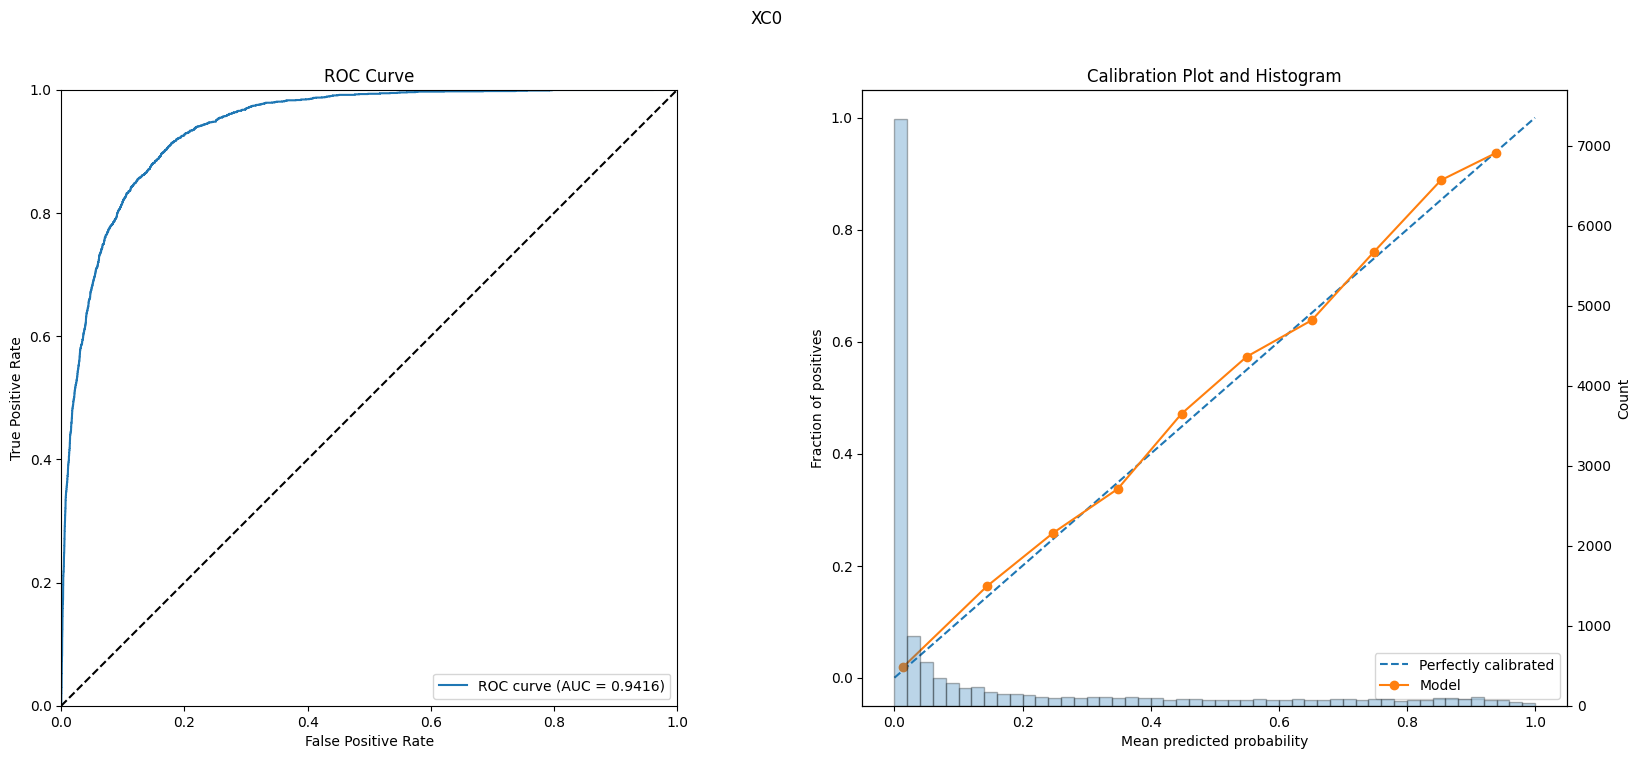

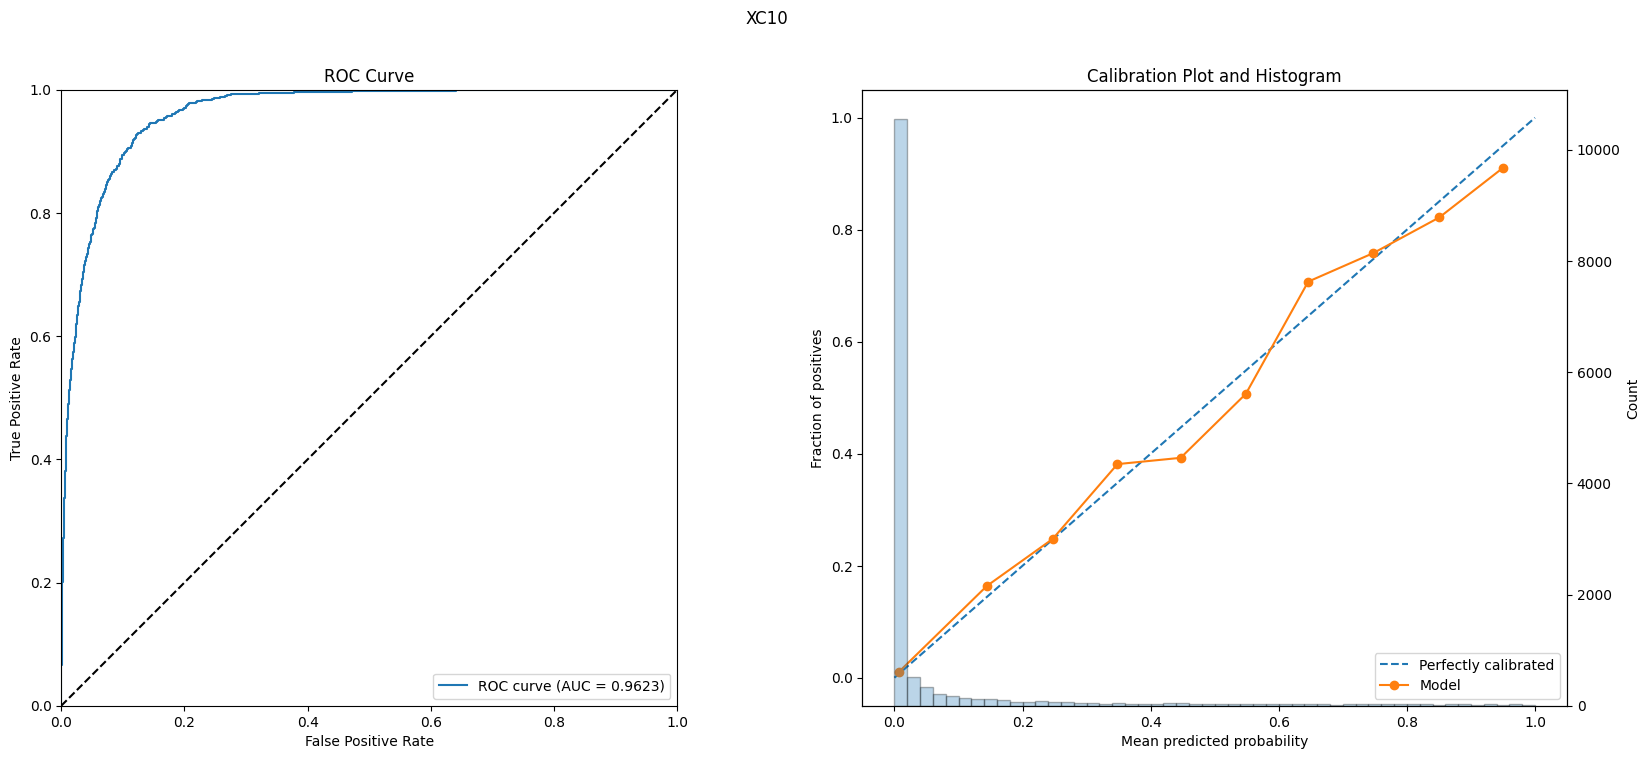

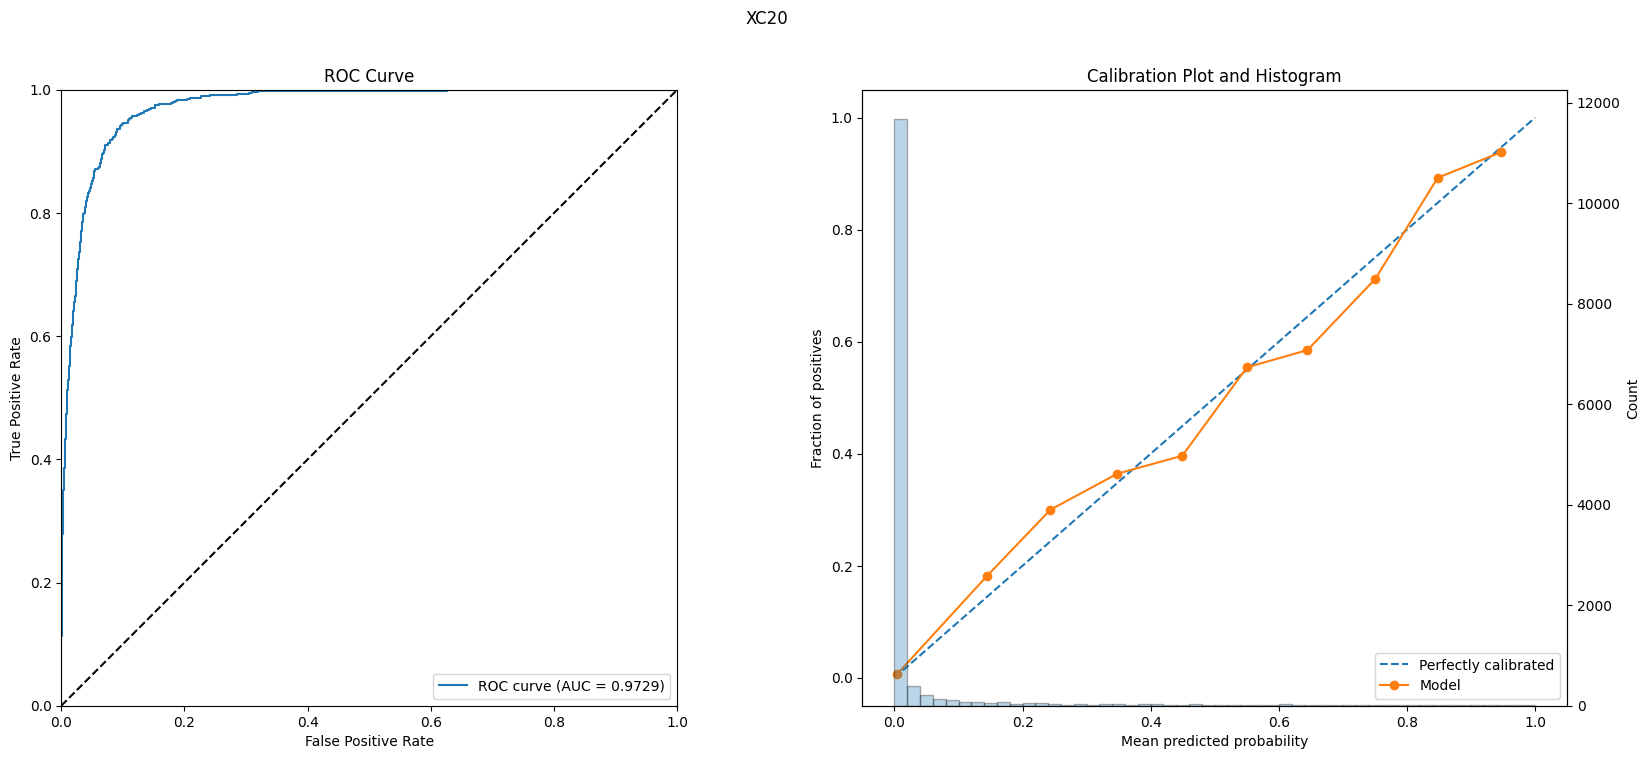

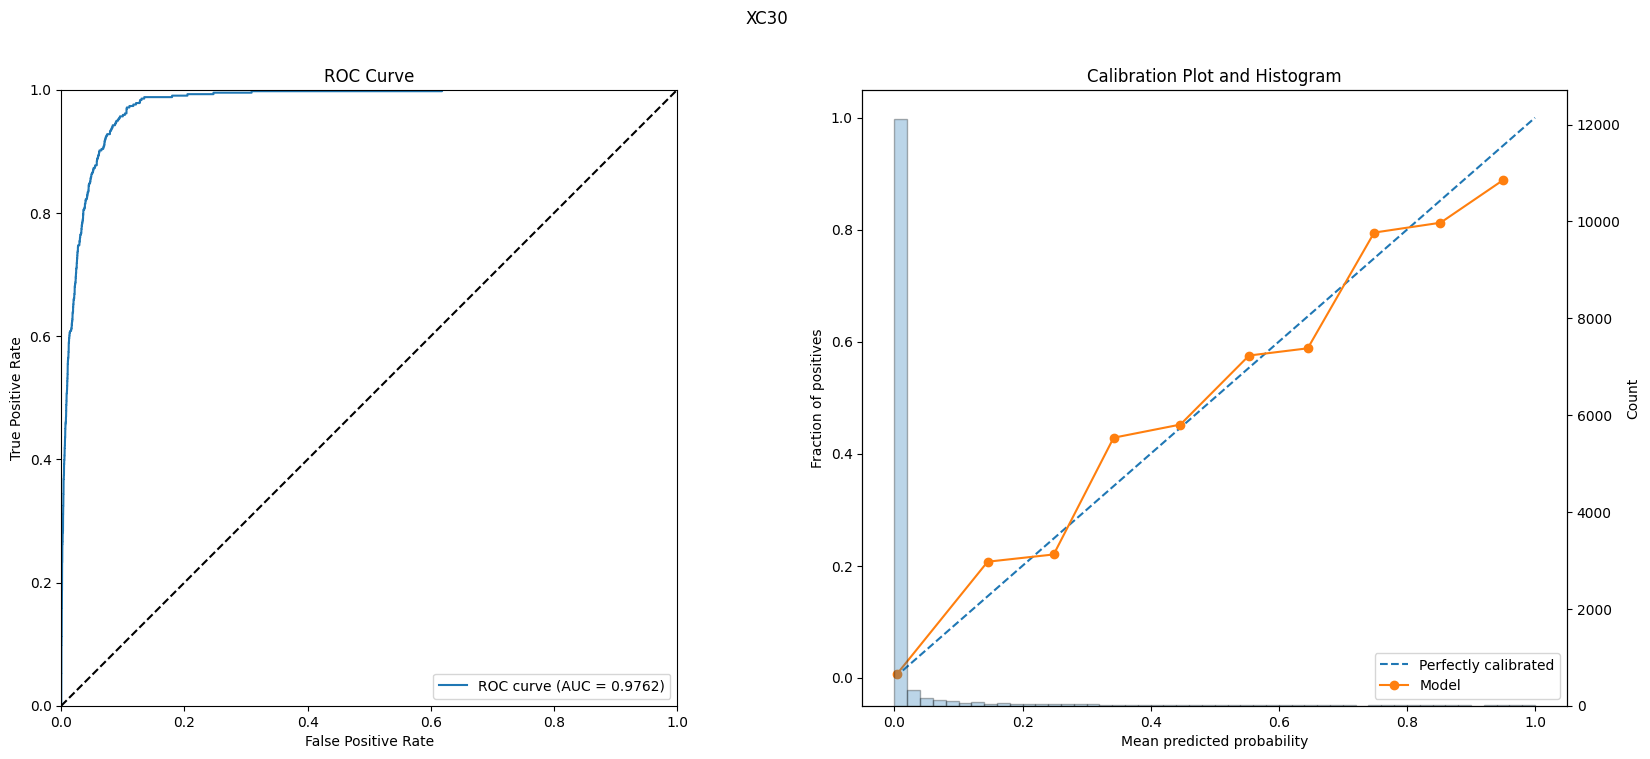

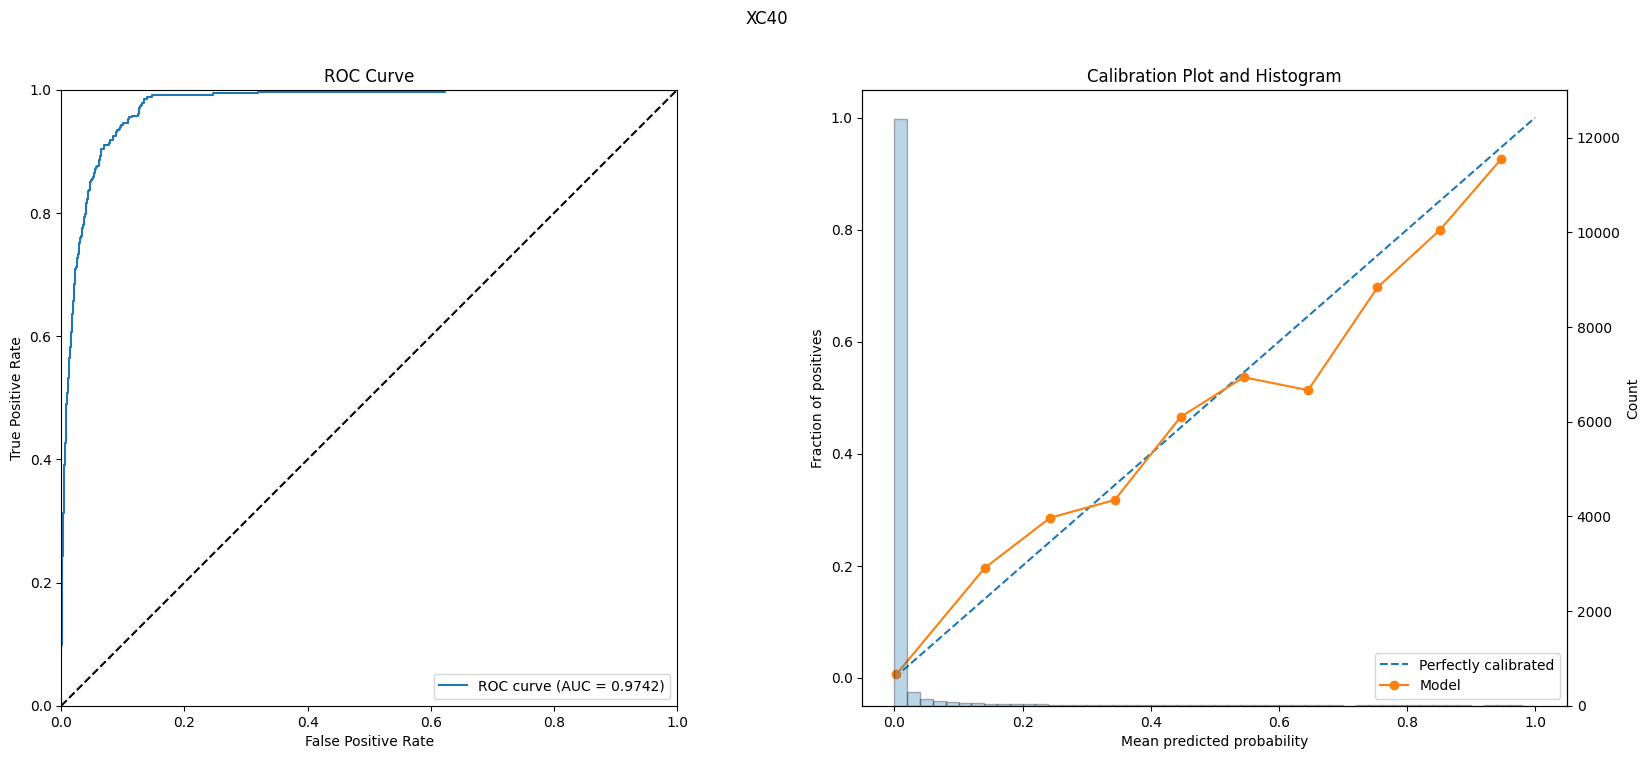

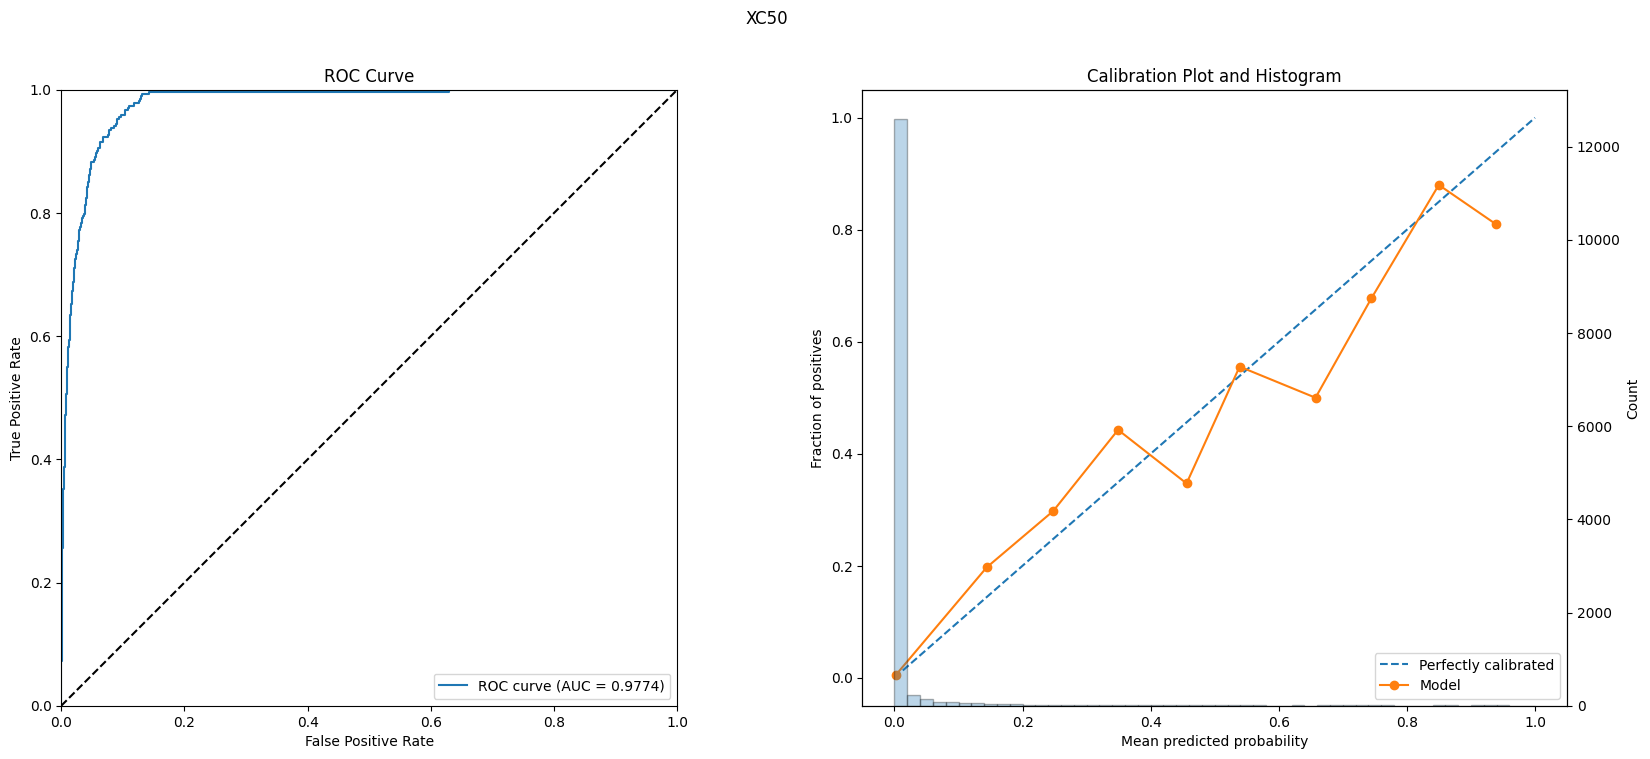

In [37]:
for i, target in enumerate(targets):
    y_pred_proba = np.array(val_predictions[:, i])
    y_val_launch = np.array(y_val[target])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
    utils.plot_roc_curve(y_val_launch, y_pred_proba, ax=ax1)
    ax1.set_title(f'ROC Curve')

    utils.plot_calibration_and_histogram(y_val_launch, y_pred_proba, ax=ax2)
    ax2.set_title(f'Calibration Plot and Histogram')
    plt.suptitle(target)
    plt.show()

In [38]:
cross_layer_weights = model.cross_net.kernels[0].data.cpu().numpy()

In [40]:
import seaborn as sns


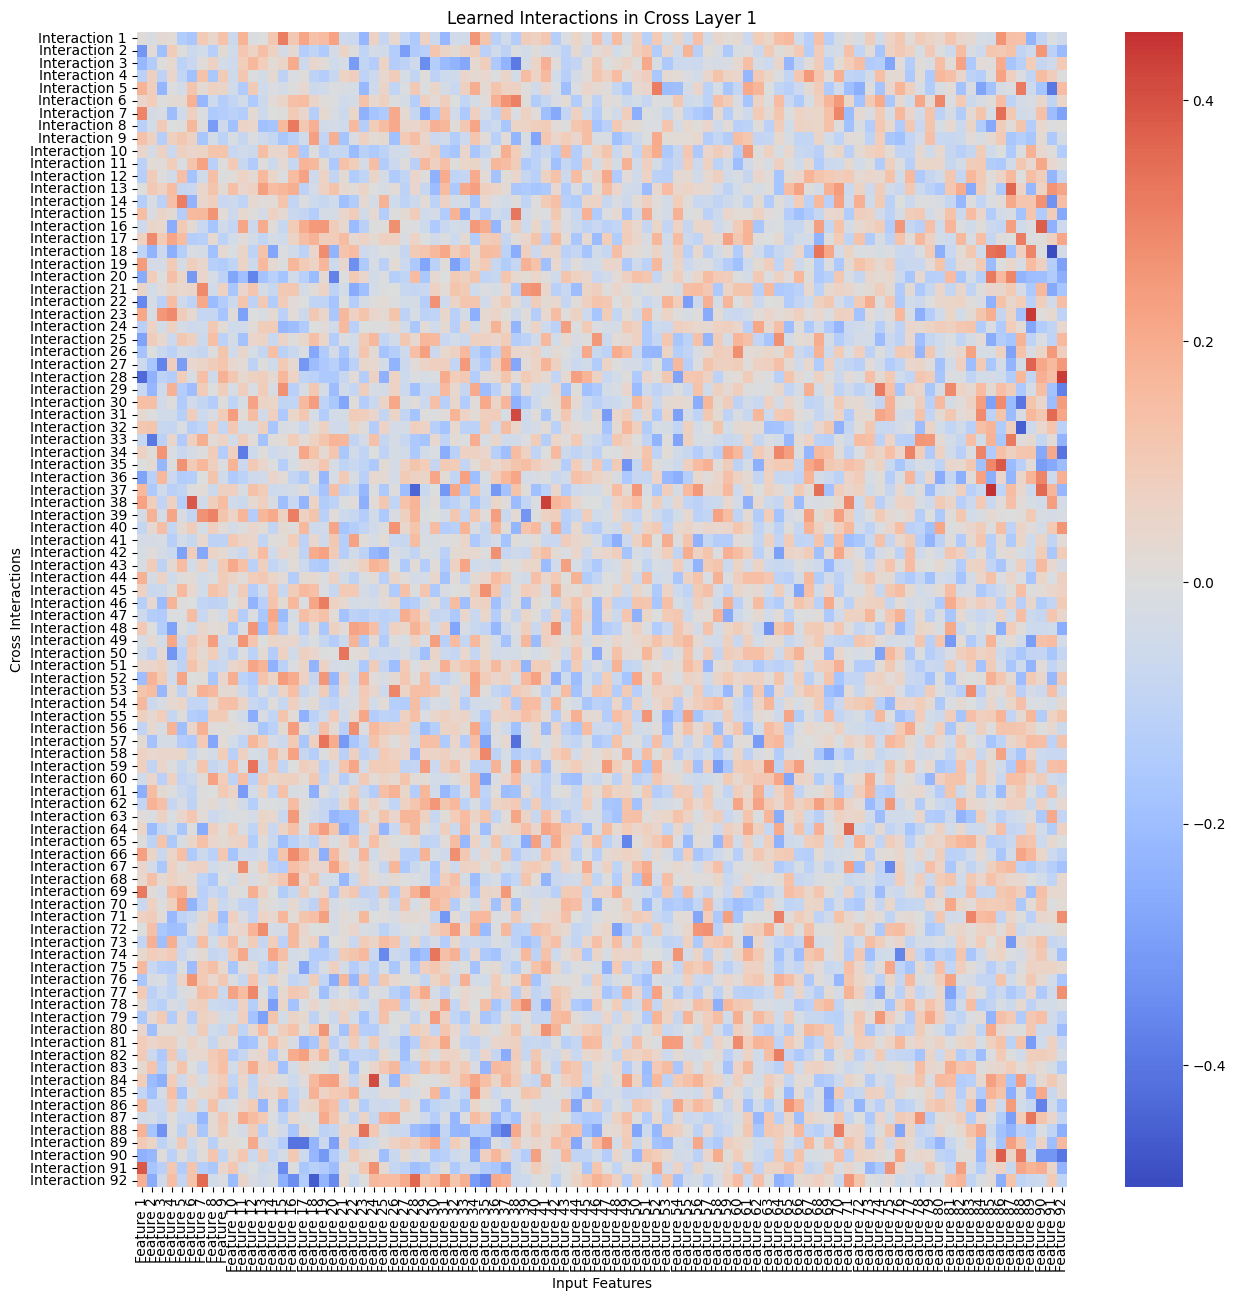

In [41]:
# Create a heatmap of the weight matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cross_layer_weights[:len(features)], annot=False, cmap='coolwarm', center=0,
            xticklabels=[f'Feature {i+1}' for i in range(num_features)],
            yticklabels=[f'Interaction {i+1}' for i in range(num_features)])

plt.title(f"Learned Interactions in Cross Layer {0 + 1}")
plt.xlabel("Input Features")
plt.ylabel("Cross Interactions")
plt.show()